In [49]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import exposure
from nilearn import plotting
%matplotlib inline
import csv
import torch
import gzip
from src.unet.loss import MixedLoss
from src.unet.lit_unet import LitUNet
import torch
from matplotlib import image
from src.rfc_dataset import RFCDataset
from torch.utils.data import ConcatDataset, DataLoader, Subset
from src.unet.loss import MixedLoss
from skimage.measure import regionprops
import matplotlib.patches as mpatches
from skimage.feature import blob_dog, blob_log, blob_doh


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load the model

In [101]:
model = LitUNet.load_from_checkpoint(
    "../checkpoints-0605-0023-ce+bd+md+rw-0.5/epoch=94-step=214158-val_bin_dice=0.18.ckpt",
)
model.to(device)
model.eval();

TypeError: __init__() missing 1 required positional argument: 'params'

## Create the validation data loader

In [4]:
def get_val_loader(batch_size=1):
    val_pos = RFCDataset(
        data_dir="../data/ribfrac-challenge/validation/prepared/pos",
    )
    val_neg = RFCDataset(
        data_dir="../data/ribfrac-challenge/validation/prepared/neg",
    )
    val_data = ConcatDataset([val_pos, val_neg])
    # val_data = Subset(val_data, torch.randperm(len(val_data)))
    val_loader = DataLoader(
        val_data, batch_size=batch_size, persistent_workers=True, num_workers=24
    )
    return val_data, val_loader


In [5]:
dataset, data_loader = get_val_loader()
print("Num validation slices:", len(data_loader))

Num validation slices: 26420


## Take a look at a single slice

In [6]:
batch_0 = dataset[700]
img_0 = batch_0["image"]
label_0 = batch_0["label"]

In [7]:
print("img shape:", img_0.shape)

img shape: torch.Size([1, 512, 512])


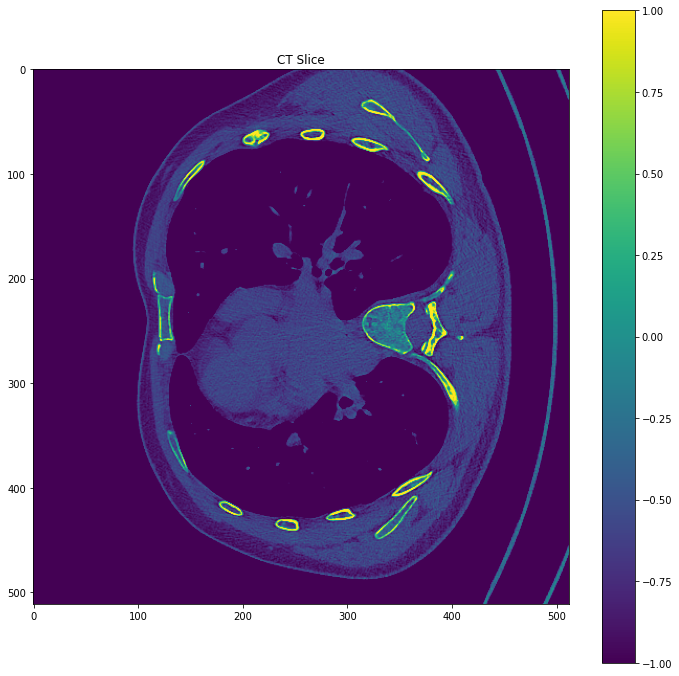

In [8]:
fig = plt.figure(figsize=(12, 12))
plt.title('CT Slice')
plt.imshow(img_0[0])
plt.colorbar()

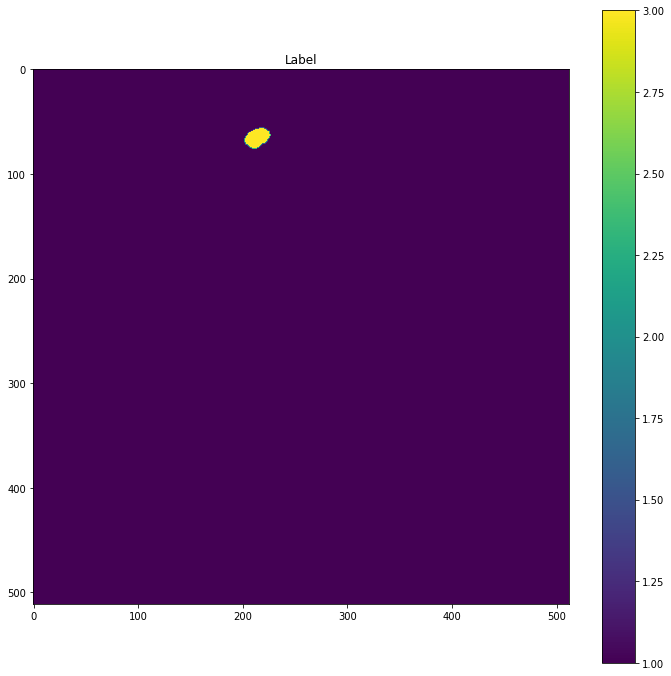

In [9]:
plt.figure(figsize=(12, 12))
plt.title('Label')
plt.imshow(label_0)
plt.colorbar()

In [10]:
print('max:', label_0.max().item())
print('min:', label_0.min().item())
print('unique label values:', label_0.unique().numpy())

max: 3
min: 1
unique label values: [1 3]


## Run model on the same slice

In [11]:
out = model(img_0.unsqueeze(0).to(device)).cpu()
probs = MixedLoss.get_softmax_scores(out)
binary_probs = (1 - probs[:, 1]).squeeze().detach().cpu().numpy()

## Set probability threshold

In [12]:
bin_prob_thresh = 0.9

In [13]:
binary_probs[binary_probs < bin_prob_thresh] = 0

In [14]:
print(binary_probs.shape)

(512, 512)


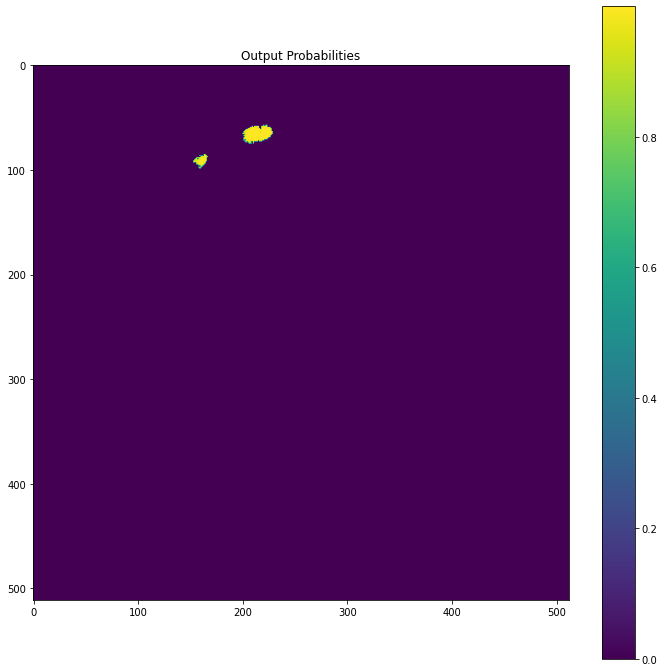

In [15]:
plt.figure(figsize=(12, 12))
plt.title('Output Probabilities')
plt.imshow(binary_probs)
plt.colorbar()

# Binary DICE

In [16]:
mixed_loss = MixedLoss(model.params)
label_0_one_hot = torch.nn.functional.one_hot(label_0.unsqueeze(0), num_classes=6)
label_0_one_hot = label_0_one_hot.type(torch.int8).permute(0, 3, 1, 2)
binary_dice = mixed_loss.get_binary_dice_score(probs, label_0.unsqueeze(0), label_0_one_hot)
print(f'Binary DICE: {binary_dice.item():.2f}')

Binary DICE: 0.65


In [17]:
def get_label_rois(label_slice):
    x = label_slice.copy()
    x[x == 0] = 5
    x[x == 1] = 0
    rois = regionprops(x)
    return rois

def get_pred_rois(bin_probs):
    x = bin_probs.copy()
    rois = regionprops(x)
    return rois

In [18]:
label_rois = get_label_rois(label_0.numpy())

In [27]:
pred_rois = get_pred_rois((binary_probs > 0).astype(np.int8))

In [28]:
print(len(label_rois))
print(len(pred_rois))

1
1


In [29]:
print(label_rois[0].centroid)
print(pred_rois[0].centroid)

(66.17595307917888, 213.70967741935485)
(71.75109170305677, 202.18995633187774)


In [30]:
print(label_rois[0].area)
print(pred_rois[0].area)

341
458


In [33]:
def IoU(img_slice, label_slice):
    return (img_slice * label_slice).sum() / (img_slice + label_slice).sum()

In [34]:
IoU((binary_probs > 0), (label_0.numpy() != 1))

0.6044176706827309

In [38]:
def bb_IoU(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [39]:
print(bb_IoU(label_rois[0].bbox, pred_rois[0].bbox))

0.15582858855259216


In [40]:
label_rois[0].bbox

(57, 202, 77, 227)

In [41]:
pred_rois[0].bbox

(58, 153, 100, 229)

In [95]:
def get_label_blobs(label_slice):
    x = label_slice.copy()
    x = x != 1
    label_blobs = blob_log(x)
    return label_blobs


In [96]:
bin_prob_blobs = blob_log(binary_probs, max_sigma=30, num_sigma=10, threshold=.5)
label_blobs = get_label_blobs(label_0.numpy())

In [97]:
print(label_blobs)

[[ 66.         214.           6.44444444]
 [ 64.         225.           1.        ]]


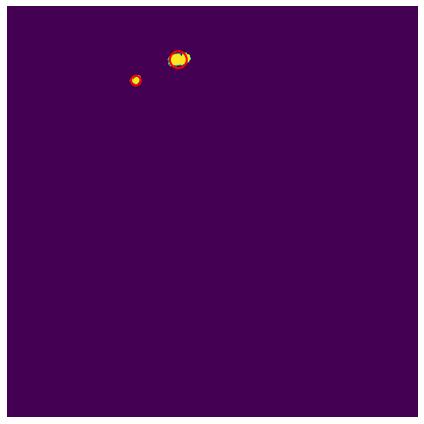

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(binary_probs)

for blob in bin_prob_blobs:
    y, x, r = blob
    r = r * np.sqrt(2)
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

ax.set_axis_off()
plt.tight_layout()
plt.show()

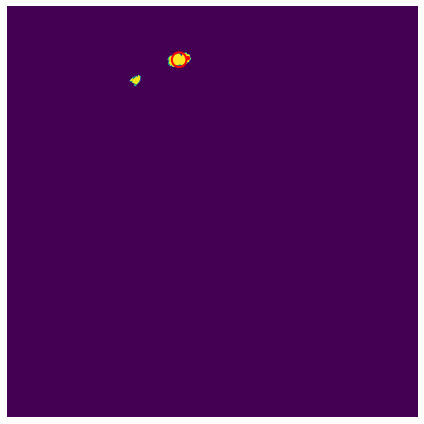

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(binary_probs)

for blob in label_blobs:
    y, x, r = blob
    r = r * np.sqrt(2)
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

ax.set_axis_off()
plt.tight_layout()
plt.show()